<a href="https://colab.research.google.com/github/tfqbasha/CSCE636_DL2/blob/master/slowfast_k_base_subsamples20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Go to the Directory
%cd /content/drive/My\ Drive/Colab\ Notebooks/CSCE636/slowfast-keras2Class/slowfast-keras
!pip install tensorflow==1.15.0
!python3 -c 'import tensorflow as tf; print(tf.__version__)'

In [0]:
#Pre-processing script
!python utils/ucf_hmdb51_frames.py ../../Data/data_clips_100_2class_jpg/

**TRAIN_CELL**

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Create resnet50 model with 2 classes
ck1
ck1 : in 
ck2: into get_ucf101
opening_refrigerator
{'opening_refrigerator': 0}
other_classes
{'opening_refrigerator': 0, 'other_classes': 1}
path_label_split: ['opening_refrigerator/0DOPEMDlGok_000042_000052.mp4', 'opening_refrigerator']
path_label_split: ['opening_refrigerator/0gK5754h_gI_000023_000033.mp4', 'opening_refrigerator']
path_label_split: ['opening_refrigerator/0i77oLVaxZY_000031_000041.mp4', 'opening_refrigerator']
path_label_split: ['opening_refrigerator/0ORnm6UF0XU_000000_000010.mp4', 'opening_refrigerator']
path_label_split: ['opening_refrigerator/0OsoFM9WR0c_000000_000010.mp4', 'opening_refrigerator']
path_label_split: ['opening_refrigerator/0pDKU8A3nPA_000000_000010.mp4', 'opening_refrigerator']
path_label_split: ['opening_refrigerator/0_X1oD9F5Os_000004_000014.mp4', 'opening_refrigerator']
path_label_split: ['opening_refrigerator/_9_nFPaaxMo_0000

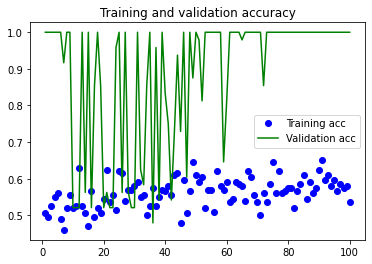

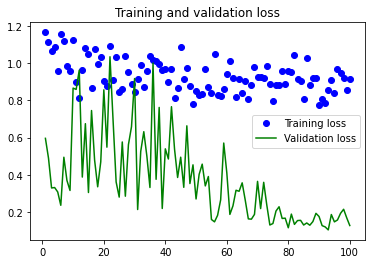

end of code


In [2]:
import os
import math
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import multi_gpu_model
from model import nets
from model import slowfast
from opts import parse_opts
from utils import get_optimizer, SGDRScheduler_with_WarmUp, TrainPrint, PrintLearningRate, ParallelModelCheckpoint
from dataset.dataset import DataGenerator

class Args:
  root_path = '/content/drive/My Drive/Colab Notebooks/CSCE636/slowfast-keras2Class/slowfast-keras'
  video_path = '/content/drive/My Drive/Colab Notebooks/CSCE636/Data/data_clips_100_2class_jpg'
  name_path = '/content/drive/My Drive/Colab Notebooks/CSCE636/Data/data_clips_100_2class_jpg/classInd.txt'
  train_list = '/content/drive/My Drive/Colab Notebooks/CSCE636/Data/data_clips_100_2class_jpg/train_new.txt'
  val_list = '/content/drive/My Drive/Colab Notebooks/CSCE636/Data/data_clips_100_2class_jpg/test_new.txt'
  result_path = 'results_0204'
  data_name = 'ntu'
  gpus = [0]
  log_dir = 'log_0204'
  num_classes = 2
  crop_size = 224
  clip_len = 64
  short_side = [256, 320]
  n_samples_for_each_video = 20
  lr = 0.00001
  momentum = 0.9
  weight_decay = 1e-4
  lr_decay = 0.8
  cycle_length = 10
  multi_factor = 1.5
  warm_up_epoch = 5
  optimizer = 'SGD'
  batch_size = 4
  epochs = 100
  workers = 4
  network = 'resnet50'
  pretrained_weights = None
  #test_videos_path = '/content/drive/My Drive/Colab Notebooks/CSCE636/Data/data_clips_100_ref_test_jpg'
  #test_list_path = '/content/drive/My Drive/Colab Notebooks/CSCE636/Data/data_clips_100_ref/test_final.txt'


def create_callbacks(opt, steps_per_epoch, model=None):
    log_dir = os.path.join(opt.root_path, opt.log_dir)
    if not os.path.exists(log_dir):
        os.mkdir(log_dir)
    tensorboard = TensorBoard(log_dir=log_dir, write_graph=True)

    result_path = os.path.join(opt.root_path, opt.result_path)
    if not os.path.exists(result_path):
        os.mkdir(result_path)

    if model is not None:
        print("mbashat: using ParallelModel")
        checkpoint = ParallelModelCheckpoint(model, os.path.join(result_path, '{epoch:03d}.h5'),
                                    monitor='val_acc', save_weights_only=True, save_best_only=True, period=1)
    else:
        print("mbashat: using ModelCheckpoint")
        checkpoint = ModelCheckpoint(os.path.join(result_path, '{epoch:03d}.h5'),
                                    monitor='val_acc', save_weights_only=True, save_best_only=True, period=1)
    early_stopping = EarlyStopping(monitor='val_acc', min_delta=0, patience=10)
    learning_rate_scheduler = SGDRScheduler_with_WarmUp(0, opt.lr, steps_per_epoch, lr_decay=opt.lr_decay, 
                                                        cycle_length=opt.cycle_length, multi_factor=opt.multi_factor,
                                                        warm_up_epoch=opt.warm_up_epoch)
    #training_print = TrainPrint(steps_per_epoch, opt.epochs)
    print_lr = PrintLearningRate()

    return [tensorboard, learning_rate_scheduler, print_lr, checkpoint, early_stopping]
    


def train(opt):
    K.clear_session()
    video_input = Input(shape=(None, None, None, 3))
    model = nets.network[opt.network](video_input, num_classes=opt.num_classes)
    print("Create {} model with {} classes".format(opt.network, opt.num_classes))

    if opt.pretrained_weights is not None:
        model.load_weights(opt.pretrained_weights)
        print("Loading weights from {}".format(opt.pretrained_weights))

    optimizer = get_optimizer(opt)

    train_data_generator = DataGenerator(opt.data_name, opt.video_path, opt.train_list, opt.name_path, 
                                        'train', opt.batch_size, opt.num_classes, True, opt.short_side, 
                                        opt.crop_size, opt.clip_len, opt.n_samples_for_each_video)                                     
    val_data_generator = DataGenerator(opt.data_name, opt.video_path, opt.val_list, opt.name_path, 'val', 
                                        opt.batch_size, opt.num_classes, False, opt.short_side, 
                                        opt.crop_size, opt.clip_len, opt.n_samples_for_each_video)
    #predict_data_generator = DataGenerator(opt.data_name, opt.test_videos_path, opt.test_list_path, opt.name_path, 
     #                                   'val', 1, opt.num_classes, False, opt.short_side, 
      #                                  opt.crop_size, opt.clip_len, opt.n_samples_for_each_video, to_fit=False)  
    
    
    callbacks = create_callbacks(opt, max(1, train_data_generator.__len__()), model)

    if len(opt.gpus) > 1:
        print('Using multi gpus')
        parallel_model = multi_gpu_model(model, gpus=len(opt.gpus))
        parallel_model.compile(optimizer=optimizer, loss=categorical_crossentropy, metrics=['accuracy'])
        parallel_model.fit_generator(train_data_generator, steps_per_epoch=max(1, train_data_generator.__len__()),
                            epochs=opt.epochs, validation_data=val_data_generator, validation_steps=max(1, val_data_generator.__len__()),
                            workers=opt.workers, callbacks=callbacks)
    else:
        print("GPU <1 run")
        model.compile(optimizer=optimizer, loss=categorical_crossentropy, metrics=['accuracy'])
        print("compile done")
        print("mbashat : Val_steps, steps_per_epoch, Val_dat", max(1, val_data_generator.__len__()), max(1, train_data_generator.__len__()), val_data_generator)
        global history_mbt
        #history_mbt = model.fit_generator(train_data_generator, steps_per_epoch=max(1, train_data_generator.__len__()),
                            #epochs=opt.epochs, validation_data=val_data_generator, validation_steps=max(1, val_data_generator.__len__()),
                            #workers=opt.workers, callbacks=callbacks)
        history_mbt = model.fit_generator(train_data_generator, steps_per_epoch=max(1, train_data_generator.__len__()), epochs=opt.epochs, validation_data=val_data_generator, validation_steps=max(1, val_data_generator.__len__()),
                        workers=opt.workers)
        
        #model.summary()
        from tensorflow.keras.utils import plot_model
        plot_model(model, to_file='model.png', show_shapes=True)
    print("model fit done")
    print("mbashat: saving model")
    model.save('SlowFast_refrigerator_0204.h5')
    #print("mbashat: saving weights at :", os.path.join(os.path.join(opt.root_path, opt.result_path) ))
    #model.save_weights(os.path.join(os.path.join(opt.root_path, opt.result_path), 'trained_weights_final_200.h5'))
    #print("mbashat: predict on val data")
    #model_predicted = model.predict(predict_data_generator)
    #import numpy as np
    #print(np.argmax(model_predicted, axis=1))
    #print("mbashat: saving weights to variable")
    #for layer in model.layers:
      #weights = layer.get_weights()
      #print(weights)
    #for video_batch, labels_batch in train_data_generator:
      #print('video batch shape, label shape:', video_batch.shape, labels_batch)
    print('printking Keys in history')
    for key in history_mbt.history:
      print(key)
    %matplotlib inline
    import matplotlib.pyplot as plt
    acc = history_mbt.history['acc']
    val_acc = history_mbt.history['val_acc']
    loss = history_mbt.history['loss']
    val_loss = history_mbt.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'g', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
    print("end of code")

if __name__=="__main__":
    opt = Args()
    print(opt)
    if len(opt.gpus) > 1:
        os.environ['CUDA_VISIBLE_DEVICES'] = ",".join(map(str, opt.gpus))
    train(opt)


**TEST_CELL**

In [0]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import multi_gpu_model
from model import nets
from model import slowfast
from opts import parse_opts
from utils import get_optimizer, SGDRScheduler_with_WarmUp, TrainPrint, PrintLearningRate, ParallelModelCheckpoint
from dataset.dataset import DataGenerator
class Args:
  root_path = '/content/drive/My Drive/Colab Notebooks/CSCE636/slowfast-keras2Class/slowfast-keras'
  video_path = '/content/drive/My Drive/Colab Notebooks/CSCE636/Data/data_clips_100_ref_jpg'
  #name_path = '/content/drive/My Drive/Colab Notebooks/CSCE636/Data/data_clips_100_ref/classInd.txt'
  name_path = '/content/drive/My Drive/Colab Notebooks/CSCE636/Data/data_clips_100_2class_jpg/classInd.txt'
  train_list = '/content/drive/My Drive/Colab Notebooks/CSCE636/Data/data_clips_100_ref/train.txt'
  val_list = '/content/drive/My Drive/Colab Notebooks/CSCE636/Data/data_clips_100_ref/test.txt'
  result_path = 'results'
  data_name = 'ntu'
  gpus = [0]
  log_dir = 'log'
  num_classes = 2
  crop_size = 224
  clip_len = 64
  short_side = [256, 320]
  n_samples_for_each_video = 1
  lr = 0.00001
  momentum = 0.9
  weight_decay = 1e-4
  lr_decay = 0.8
  cycle_length = 10
  multi_factor = 1.5
  warm_up_epoch = 5
  optimizer = 'SGD'
  batch_size = 1
  epochs = 30
  workers = 4
  network = 'resnet50'
  pretrained_weights = None
  test_videos_path = '/content/drive/My Drive/Colab Notebooks/CSCE636/Data/data_clips_100_ref_jpg'
  test_list_path = '/content/drive/My Drive/Colab Notebooks/CSCE636/Data/data_clips_100_ref/test_final.txt'
from tensorflow.keras.layers import Layer, InputSpec
opt = Args()
# load model
model = tf.keras.models.load_model('SlowFast_refrigerator_2803.h5')
# summarize model.
#model.summary()
predict_data_generator = DataGenerator(opt.data_name, opt.test_videos_path, opt.test_list_path, opt.name_path, 
                                        'val', 1, opt.num_classes, False, opt.short_side, 
                                        opt.crop_size, opt.clip_len, opt.n_samples_for_each_video, to_fit=False)  
model_predicted = model.predict(predict_data_generator)
import numpy as np
print(np.argmax(model_predicted, axis=1))